In [17]:
# Crawling data requires time and bypassing the anti-crawling mechanism, 
# so it takes time and cannot be successful every time.
# If you just want to experience data analysis,
# please move to the bottom to start the code for data analysis and visualization.
# Data is crawled based on the two videos with the highest playback volume before and after the epidemic time nodes.
# Import necessary libraries
# Set up Selenium WebDriver for web scraping
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import requests
import json
import pandas as pd
import xml.etree.ElementTree as ET
import time
from datetime import datetime

# Set up ChromeDriver
chrome_driver_path = "YOUR_CHROMEDRIVER_PATH_HERE" 
service = Service(chrome_driver_path)
# Configure Selenium WebDriver
# Set up Selenium WebDriver for web scraping
driver = webdriver.Chrome(service=service)

# Function to get video AID and CID
def get_aid_cid(bv_id):
    url = f"https://api.bilibili.com/x/web-interface/view?bvid={bv_id}"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if "data" in data:
            return data["data"].get("aid"), data["data"].get("cid")
    return None, None

# Function to get comments (hot + latest + replies)
def get_comments(aid, max_pages=10):
    comments = []
    headers = {"User-Agent": "Mozilla/5.0"}
    
    for mode in [3, 2]:  # Mode 3: Hot, Mode 2: Latest
        for page in range(1, max_pages + 1):
            url = f"https://api.bilibili.com/x/v2/reply/main?type=1&oid={aid}&mode={mode}&pn={page}"
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                data = response.json()
                if "data" in data and "replies" in data["data"]:
                    for reply in data["data"]["replies"]:
                        comment_text = reply["content"]["message"]
                        likes = reply["like"]
                        timestamp = reply["ctime"]
                        formatted_time = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
                        comments.append({"type": "comment", "text": comment_text, "likes": likes, "time": formatted_time})
                        
                        # Fetch replies (secondary comments)
                        if reply["rcount"] > 0:
                            sub_url = f"https://api.bilibili.com/x/v2/reply/reply?oid={aid}&pn=1&type=1&root={reply['rpid']}"
                            sub_response = requests.get(sub_url, headers=headers)
                            if sub_response.status_code == 200:
                                sub_data = sub_response.json()
                                if "data" in sub_data and "replies" in sub_data["data"]:
                                    for sub_reply in sub_data["data"]["replies"]:
                                        sub_text = sub_reply["content"]["message"]
                                        sub_likes = sub_reply["like"]
                                        sub_timestamp = sub_reply["ctime"]
                                        sub_time = datetime.fromtimestamp(sub_timestamp).strftime('%Y-%m-%d %H:%M:%S')
                                        comments.append({"type": "comment", "text": sub_text, "likes": sub_likes, "time": sub_time})
    return comments

# Function to get danmaku (bullet comments) with timestamps
def get_danmaku(cid):
    url = f"https://api.bilibili.com/x/v1/dm/list.so?oid={cid}"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    response.encoding = "utf-8"
    danmaku_list = []
    if response.status_code == 200:
        root = ET.fromstring(response.text)
        for d in root.findall(".//d"):
            attributes = d.attrib.get("p", "").split(",")
            if len(attributes) > 4:
                timestamp = int(attributes[4])  # Get Unix timestamp
                formatted_time = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
            else:
                formatted_time = None
            danmaku_list.append({"type": "danmaku", "text": d.text, "time": formatted_time, "likes": None})
    return danmaku_list

# Target videos
video_urls = [
    "https://www.bilibili.com/video/BV1CT411k7LB/?spm_id_from=333.337.search-card.all.click&vd_source=a38264f53a96cd55d394ebfae30751b4",
    "https://www.bilibili.com/video/BV124411k76s/?spm_id_from=333.337.search-card.all.click&vd_source=a38264f53a96cd55d394ebfae30751b4"
]

# Store extracted data
data = []
for url in video_urls:
    bv_id = url.split("/")[-2]
    aid, cid = get_aid_cid(bv_id)
    if aid and cid:
        comments = get_comments(aid)
        danmaku = get_danmaku(cid)
        data.extend(comments + danmaku)

# Convert to DataFrame
output_df = pd.DataFrame(data)

output_path = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_3.csv"
# Save processed data to a CSV file
output_df.to_csv(output_path, index=False, encoding="utf-8-sig")

# Log progress for debugging and tracking
print(f"Data has been saved to {output_path}")
driver.quit()


Data has been saved to C:\Users\wusiq\Desktop\2\bilibili_data_3.csv


In [21]:
# Clean the data and remove the less constructive remarks.
# Import necessary libraries
import pandas as pd
import re
# Load the CSV file
file_path = r"C:\Users\wusiq\Desktop\2\bilibili_data_3.csv"
# Load dataset from file
df = pd.read_csv(file_path)

# Define a function to filter out meaningless text
def is_meaningful(text):
    if pd.isna(text) or not isinstance(text, str):
        return False
    text = text.strip()
    meaningless_patterns = [
        r'^\s*$',                 # Empty or whitespace only
        r'^(哈哈哈+|233+|666+)$', # Common meaningless phrases
        r'^[0-9]+$',              # Pure numbers
        r'^[a-zA-Z]+$',           # Single-word English (e.g., "yes", "ok")
        r'^…+$',                  # Only ellipses
        r'^[！？]+$',             # Only punctuation
        r'^啊+$',                  # Repeated characters (e.g., "啊啊啊")
    ]
    for pattern in meaningless_patterns:
        if re.match(pattern, text):
            return False
    return True

# Apply the filter to remove meaningless comments and danmaku
# Apply function to dataset
# Apply function element-wise to dataset
df_cleaned = df[df["text"].apply(is_meaningful)]

# Save the cleaned data to a new CSV file
cleaned_file_path = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_3_cleaned.csv"
# Save data to CSV file
# Save processed data to a CSV file
df_cleaned.to_csv(cleaned_file_path, index=False, encoding="utf-8-sig")

# Log progress messages
# Log progress for debugging and tracking
print(f"Cleaned data has been saved to {cleaned_file_path}")


Cleaned data has been saved to C:\Users\wusiq\Desktop\2\bilibili_data_3_cleaned.csv


In [22]:
#Balanced Data Processing Script
#1.Identifying the dataset with the smallest size.
#2.Randomly sampling larger datasets to match the smallest dataset.
#3.Saving the balanced datasets for fair analysis.
# Import necessary libraries
import pandas as pd
# Load cleaned data files
file1 = r"C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_cleaned.csv"
file2 = r"C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_2_cleaned.csv"
file3 = r"C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_3_cleaned.csv"

# Load dataset from file
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
# Load dataset
# Load dataset from file
df3 = pd.read_csv(file3)

# Determine the minimum dataset size
min_size = min(len(df1), len(df2), len(df3))

# Randomly downsample larger datasets to match the smallest size
df1_balanced = df1.sample(n=min_size, random_state=42)
df2_balanced = df2.sample(n=min_size, random_state=42)
df3_balanced = df3.sample(n=min_size, random_state=42)

# Save the balanced datasetse
# Save processed data to a CSV file
df1_balanced.to_csv("C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_1_balanced.csv", index=False, encoding="utf-8-sig")
df2_balanced.to_csv("C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_2_balanced.csv", index=False, encoding="utf-8-sig")
df3_balanced.to_csv("C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_3_balanced.csv", index=False, encoding="utf-8-sig")

# Log progress for debugging and tracking
print("Balanced datasets have been saved successfully.")


Balanced datasets have been saved successfully.


Processed dataset saved: C:\Users\wusiq\Desktop\2\bilibili_data_combined_sentiment.csv
Sentiment analysis visualization has been saved to: C:\Users\wusiq\Desktop\2\sentiment_analysis_combined.png


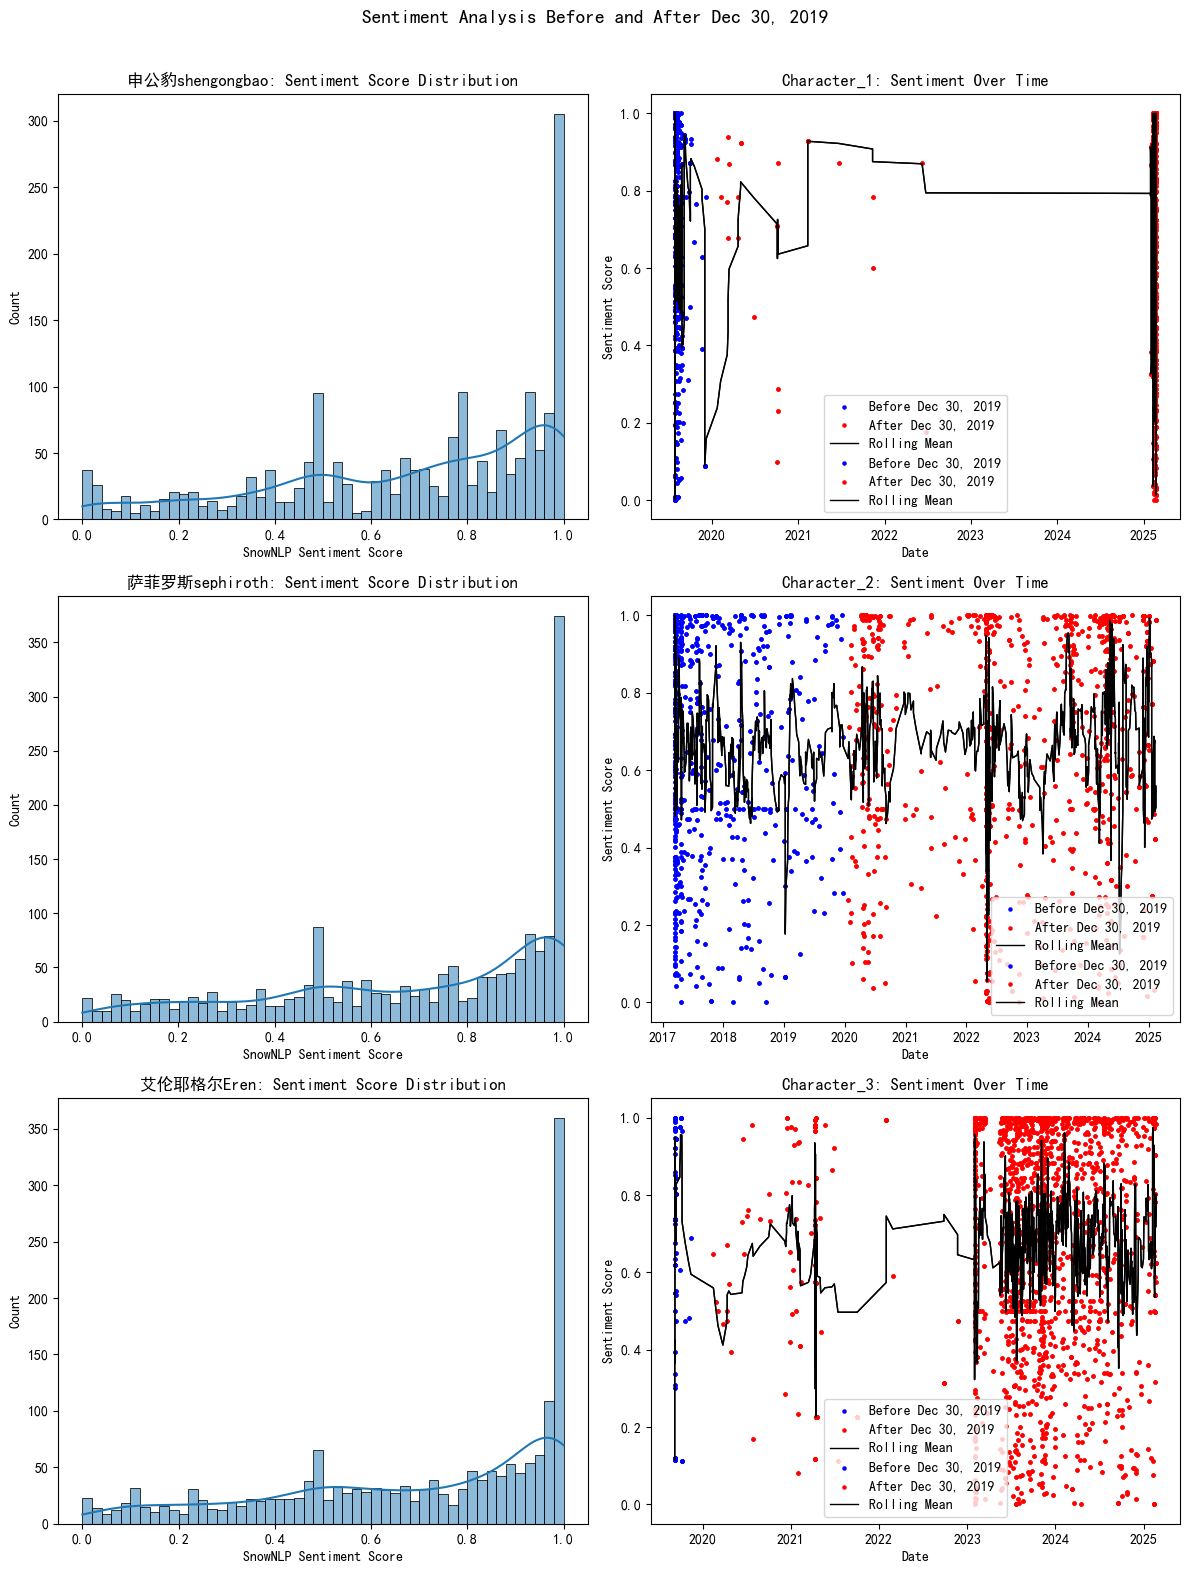

In [30]:
# ========================== Step 1: Import Necessary Libraries ==========================
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
from snownlp import SnowNLP

# Set font to a Chinese-supported font to ensure correct rendering
plt.rcParams['font.sans-serif'] = ['SimHei']  # Use SimHei (黑体) for Chinese text
plt.rcParams['axes.unicode_minus'] = False  # Ensure minus signs are displayed correctly

# ========================== Step 2: Load Datasets ==========================

# Define file paths for three datasets
file1 = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_1_balanced.csv"
file2 = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_2_balanced.csv"
file3 = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_3_balanced.csv"

# Load dataset from file
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

# Assign character labels to each dataset
df1["character"] = "Character_1"
df2["character"] = "Character_2"
df3["character"] = "Character_3"

# ========================== Step 3: Combine Datasets ==========================

# Merge all datasets into a single DataFrame
df_combined = pd.concat([df1, df2, df3], ignore_index=True)

# Convert "time" column to datetime format for time-based analysis
df_combined["time"] = pd.to_datetime(df_combined["time"], errors="coerce")

# ========================== Step 4: Apply Sentiment Analysis ==========================

# Use SnowNLP to analyze sentiment for each comment
# SnowNLP returns a sentiment score between 0 (negative) and 1 (positive)
df_combined["sentiment"] = df_combined["text"].apply(lambda x: SnowNLP(str(x)).sentiments if pd.notna(x) else None)

# Save the processed dataset with sentiment scores for further analysis
processed_file = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_combined_sentiment.csv"
df_combined.to_csv(processed_file, index=False, encoding="utf-8-sig")
# Print a confirmation message after successful processing
print(f"Processed dataset saved: {processed_file}")

# ========================== Step 5: Define Analysis Parameters ==========================

# Set the cutoff date for pre-pandemic and post-pandemic analysis
pandemic_date = datetime(2019, 12, 30)
# Create a figure with subplots for three characters
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))
fig.suptitle("Sentiment Analysis Before and After Dec 30, 2019", fontsize=14)
# Define character name mappings for visualization
character_mapping = {
    "Character_1": "申公豹shengongbao",
    "Character_2": "萨菲罗斯sephiroth",
    "Character_3": "艾伦耶格尔Eren"
}

# ========================== Step 6: Visualization Function ==========================
def plot_sentiment(character, row_idx):
    """
    Function to plot sentiment distribution and trend over time for a given character.

    Parameters:
    - character (str): Character identifier (e.g., "Character_1")
    - row_idx (int): Row index for subplot positioning
    """
    df_character = df_combined[df_combined["character"] == character]

    # Get the correct display name using the character mapping
    display_name = character_mapping.get(character, character)  # Default to original if not found


    # ========================== Left Plot: Sentiment Score Distribution ==========================
    sns.histplot(df_character["sentiment"], bins=50, kde=True, ax=axes[row_idx, 0])
    axes[row_idx, 0].set_title(f"{display_name}: Sentiment Score Distribution")  # Use mapped name
    axes[row_idx, 0].set_xlabel("SnowNLP Sentiment Score")
    axes[row_idx, 0].set_ylabel("Count")


    # ========================== Right Plot: Sentiment Over Time ==========================
    # Remove missing time values to ensure correct ordering
    df_character = df_character.dropna(subset=["time"])
    df_character_sorted = df_character.sort_values(by="time")

    # Scatter plot for sentiment scores before and after the pandemic boundary
    axes[row_idx, 1].scatter(
        df_character_sorted[df_character_sorted["time"] < pandemic_date]["time"],
        df_character_sorted[df_character_sorted["time"] < pandemic_date]["sentiment"],
        color="blue", label="Before Dec 30, 2019", s=5
    )
    axes[row_idx, 1].scatter(
        df_character_sorted[df_character_sorted["time"] >= pandemic_date]["time"],
        df_character_sorted[df_character_sorted["time"] >= pandemic_date]["sentiment"],
        color="red", label="After Dec 30, 2019", s=5
    )

    # Compute rolling mean to visualize trend if sufficient data points exist
    if len(df_character_sorted) > 10:
        df_character_sorted["rolling_mean"] = df_character_sorted["sentiment"].rolling(window=10, min_periods=1).mean()
        axes[row_idx, 1].plot(df_character_sorted["time"], df_character_sorted["rolling_mean"], color="black", linewidth=1, label="Rolling Mean")

    # Formatting the right-side plot
    axes[row_idx, 1].set_title(f"{display_name}: Sentiment Over Time")  # Use mapped name
    axes[row_idx, 1].set_xlabel("Date")
    axes[row_idx, 1].set_ylabel("Sentiment Score")
    axes[row_idx, 1].legend()


    axes[row_idx, 1].scatter(
        df_character_sorted[df_character_sorted["time"] < pandemic_date]["time"],
        df_character_sorted[df_character_sorted["time"] < pandemic_date]["sentiment"],
        color="blue", label="Before Dec 30, 2019", s=5
    )
    axes[row_idx, 1].scatter(
        df_character_sorted[df_character_sorted["time"] >= pandemic_date]["time"],
        df_character_sorted[df_character_sorted["time"] >= pandemic_date]["sentiment"],
        color="red", label="After Dec 30, 2019", s=5
    )

    # Rolling mean trendline
    if len(df_character_sorted) > 10:
        df_character_sorted["rolling_mean"] = df_character_sorted["sentiment"].rolling(window=10, min_periods=1).mean()
        axes[row_idx, 1].plot(df_character_sorted["time"], df_character_sorted["rolling_mean"], color="black", linewidth=1, label="Rolling Mean")

    axes[row_idx, 1].set_title(f"{character}: Sentiment Over Time")
    axes[row_idx, 1].set_xlabel("Date")
    axes[row_idx, 1].set_ylabel("Sentiment Score")
    axes[row_idx, 1].legend()

# Loop through each character and plot sentiment analysis
characters = ["Character_1", "Character_2", "Character_3"]
for i, character in enumerate(characters):
    plot_sentiment(character, i)

# ========================== Step 7: Save and Display the Plots ==========================
# Adjust layout to prevent overlapping
# Define the output path for the visualization
plot_path = "C:\\Users\\wusiq\\Desktop\\2\\sentiment_analysis_combined.png"
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(plot_path)

# Print confirmation message after saving the plot
print(f"Sentiment analysis visualization has been saved to: {plot_path}")


In [39]:
# ========================== Step 1: Import Necessary Libraries ==========================
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

# ========================== Step 2: Load Processed Sentiment Dataset ==========================

# Define the file path for the processed sentiment dataset
file_path = r"C:\Users\wusiq\Desktop\2\bilibili_data_combined_sentiment.csv"

# Load dataset containing sentiment analysis results
df_sentiment = pd.read_csv(file_path)

# ========================== Step 3: Load Original Datasets for Data Augmentation ==========================

# Define file paths for original cleaned datasets
file1 = r"C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_cleaned.csv"
file2 = r"C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_2_cleaned.csv"
file3 = r"C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_3_cleaned.csv"

# Load original datasets before sentiment analysis
df_raw1 = pd.read_csv(file1)
df_raw2 = pd.read_csv(file2)
df_raw3 = pd.read_csv(file3)

# Assign character labels to each dataset for proper identification
df_raw1["character"] = "申公豹shengongbao"
df_raw2["character"] = "萨菲罗斯sephiroth"
df_raw3["character"] = "艾伦耶格尔Eren"

# Combine all original datasets into one for further analysis
df_raw_combined = pd.concat([df_raw1, df_raw2, df_raw3], ignore_index=True)

# ========================== Step 4: Convert Timestamp Format ==========================

# Convert "time" column to datetime format in both sentiment and original datasets
df_sentiment["time"] = pd.to_datetime(df_sentiment["time"], errors="coerce")
df_raw_combined["time"] = pd.to_datetime(df_raw_combined["time"], errors="coerce")

# Define the boundary date for pandemic-related sentiment analysis
pandemic_date = datetime(2019, 12, 30)

# ========================== Step 5: Data Augmentation (Balancing Pre-Pandemic Data) ==========================

# Create a copy of the sentiment dataset to store augmented data
df_augmented = df_sentiment.copy()

# Set a minimum target number of samples for pre-pandemic data
target_samples = 300

# Retrieve the unique character labels in the dataset
characters = df_sentiment["character"].unique()

# Iterate over each character dataset to balance pre-pandemic samples
for character in characters:
    # Extract pre- and post-pandemic data for the character
    df_character = df_sentiment[df_sentiment["character"] == character]
    pre_pandemic = df_character[df_character["time"] < pandemic_date]
    post_pandemic = df_character[df_character["time"] >= pandemic_date]

    # Get the number of samples before and after the pandemic
    pre_count = len(pre_pandemic)
    post_count = len(post_pandemic)

    # If pre-pandemic data is insufficient, supplement it with additional samples
    if pre_count < target_samples:
        print(f"Supplementing {character}: Pre-Pandemic Count = {pre_count}")
        
        # Select pre-pandemic data from the original dataset
        df_raw_character = df_raw_combined[(df_raw_combined["character"] == character) & (df_raw_combined["time"] < pandemic_date)]
        
        # Determine the number of samples needed to meet the target
        needed_samples = target_samples - pre_count

        # If enough samples exist, select a random subset; otherwise, use all available samples
        if len(df_raw_character) >= needed_samples:
            sampled_data = df_raw_character.sample(n=needed_samples, replace=False, random_state=42)
        else:
            sampled_data = df_raw_character
        
        # Append the sampled data to the augmented dataset
        df_augmented = pd.concat([df_augmented, sampled_data], ignore_index=True)
# ========================== Step 6: Save Augmented Dataset ==========================

# Define the output file path for the augmented dataset
augmented_file_path = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_augmented.csv"

# # Save the augmented dataset with balanced pre-pandemic data
df_augmented.to_csv(augmented_file_path, index=False, encoding="utf-8-sig")

# Print a confirmation message after saving the augmented dataset
print(f"Augmented dataset saved: {augmented_file_path}")

# ========================== Step 7: Define Function for Statistical Testing ==========================

def perform_statistical_tests(character_name):
    """
    Performs two statistical tests (t-test and Mann-Whitney U test) to determine whether 
    sentiment scores significantly changed before and after the pandemic.

    Parameters:
    - character_name (str): The name of the character being analyzed

    Outputs:
    - Prints t-test and Mann-Whitney U test results
    """
    
    # Extract sentiment data for the specified character
    df_character = df_augmented[df_augmented["character"] == character_name]
    

    # Separate sentiment scores into pre-pandemic and post-pandemic groups
    pre_pandemic = df_character[df_character["time"] < pandemic_date]["sentiment"].dropna()
    post_pandemic = df_character[df_character["time"] >= pandemic_date]["sentiment"].dropna()

    # Check if there are enough data points to perform statistical tests
    if len(pre_pandemic) < 10 or len(post_pandemic) < 10:
        print(f"Skipping {character_name}: Not enough data for statistical tests.")
        return
    
    # Perform an independent t-test (parametric test) to compare mean sentiment scores
    t_stat, t_p_value = stats.ttest_ind(pre_pandemic, post_pandemic, equal_var=False, nan_policy='omit')
    
    # Perform a Mann-Whitney U test (non-parametric test) to compare distributions
    u_stat, u_p_value = stats.mannwhitneyu(pre_pandemic, post_pandemic, alternative='two-sided')
    
    # Print the results of the statistical tests
    print(f"=== Statistical Test Results for {character_name} ===")
    print(f"t-test: t-statistic = {t_stat:.3f}, p-value = {t_p_value:.3f}")
    print(f"Mann-Whitney U test: U-statistic = {u_stat:.3f}, p-value = {u_p_value:.3f}")
    print("-" * 50)

# ========================== Step 8: Run Statistical Tests for Each Character ==========================

# Perform the statistical tests for each character in the dataset
for character in characters:
    perform_statistical_tests(character)


Supplementing Character_3: Pre-Pandemic Count = 86
Augmented dataset saved: C:\Users\wusiq\Desktop\2\bilibili_data_augmented.csv
=== Statistical Test Results for Character_1 ===
t-test: t-statistic = 1.874, p-value = 0.061
Mann-Whitney U test: U-statistic = 397225.000, p-value = 0.236
--------------------------------------------------
=== Statistical Test Results for Character_2 ===
t-test: t-statistic = -0.131, p-value = 0.896
Mann-Whitney U test: U-statistic = 392680.000, p-value = 0.731
--------------------------------------------------
=== Statistical Test Results for Character_3 ===
t-test: t-statistic = 0.875, p-value = 0.384
Mann-Whitney U test: U-statistic = 77936.000, p-value = 0.358
--------------------------------------------------


In [40]:
# ========================== Step 1: Import Necessary Libraries ==========================
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

# ========================== Step 2: Load and Prepare Data ==========================

# Define the file path for the augmented dataset
file_path = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_augmented.csv"
# Load the dataset containing sentiment scores and metadata
df = pd.read_csv(file_path)

# Convert 'time' column to datetime format for proper time-based filtering
df["time"] = pd.to_datetime(df["time"], errors="coerce")

# Define the pandemic boundary for time-based analysis
pandemic_date = datetime(2019, 12, 30)

# Define thresholds for high and low like counts
high_like_threshold = 50 # Comments with more than 50 likes are considered highly liked
low_like_threshold = 5 # Comments with 5 or fewer likes are considered low engagement

# ========================== Step 3: Define Function for Statistical Testing ==========================

def perform_tests(subset_name, df_subset):
     """
    Perform statistical tests (t-test and Mann-Whitney U test) on sentiment scores 
    before and after the pandemic.

    Parameters:
    - subset_name (str): A label for the dataset subset being tested.
    - df_subset (DataFrame): A subset of the dataset containing sentiment scores.

    Outputs:
    - Prints t-test and Mann-Whitney U test results.
    """
    
    # Separate pre-pandemic and post-pandemic sentiment scores
    pre_pandemic = df_subset[df_subset["time"] < pandemic_date]["sentiment"].dropna()
    post_pandemic = df_subset[df_subset["time"] >= pandemic_date]["sentiment"].dropna()

    # Ensure sufficient data is available for statistical tests
    if len(pre_pandemic) < 10 or len(post_pandemic) < 10:
        print(f"Skipping {subset_name}: Not enough data for statistical tests.")
        return
    
    # Perform an independent t-test (parametric test) to compare mean sentiment scores
    t_stat, t_p_value = stats.ttest_ind(pre_pandemic, post_pandemic, equal_var=False, nan_policy='omit')

    # Perform a Mann-Whitney U test (non-parametric test) to compare sentiment distributions
    u_stat, u_p_value = stats.mannwhitneyu(pre_pandemic, post_pandemic, alternative='two-sided')

    # Print the results of the statistical tests
    print(f"=== Statistical Test Results for {subset_name} ===")
    print(f"t-test: t-statistic = {t_stat:.3f}, p-value = {t_p_value:.3f}")
    print(f"Mann-Whitney U test: U-statistic = {u_stat:.3f}, p-value = {u_p_value:.3f}")
    print("-" * 50)

# ========================== Step 4: Perform Statistical Tests for Each Character ==========================

# Retrieve the unique character labels in the dataset
characters = df["character"].unique()
# Iterate over each character's dataset to perform statistical tests
for character in characters:
    # Extract all comments associated with the current character
    df_character = df[df["character"] == character]
  
    # ========================== Analysis Based on Like Count ==========================

    # Analyze sentiment changes for comments with a high number of likes
    df_high_like = df_character[df_character["likes"] > high_like_threshold]
    perform_tests(f"{character} - High Likes (>50)", df_high_like)

    # Analyze sentiment changes for comments with a low number of likes
    df_low_like = df_character[df_character["likes"] <= low_like_threshold]
    perform_tests(f"{character} - Low Likes (≤5)", df_low_like)

    # ========================== Analysis Based on Yearly Trends ==========================

    # Extract comments from different time periods for trend analysis
    df_2019_earlier = df_character[df_character["time"].dt.year <= 2019]
    df_2020_2021 = df_character[(df_character["time"].dt.year >= 2020) & (df_character["time"].dt.year <= 2021)]
    df_2022_later = df_character[df_character["time"].dt.year >= 2022]

    # Perform statistical tests for different time periods
    perform_tests(f"{character} - 2019 & Earlier", df_2019_earlier)
    perform_tests(f"{character} - 2020-2021", df_2020_2021)
    perform_tests(f"{character} - 2022 & Later", df_2022_later)


=== Statistical Test Results for Character_1 - High Likes (>50) ===
t-test: t-statistic = -1.590, p-value = 0.113
Mann-Whitney U test: U-statistic = 20400.000, p-value = 0.025
--------------------------------------------------
=== Statistical Test Results for Character_1 - Low Likes (≤5) ===
t-test: t-statistic = 3.538, p-value = 0.001
Mann-Whitney U test: U-statistic = 10400.000, p-value = 0.195
--------------------------------------------------
Skipping Character_1 - 2019 & Earlier: Not enough data for statistical tests.
Skipping Character_1 - 2020-2021: Not enough data for statistical tests.
Skipping Character_1 - 2022 & Later: Not enough data for statistical tests.
=== Statistical Test Results for Character_2 - High Likes (>50) ===
t-test: t-statistic = 5.936, p-value = 0.000
Mann-Whitney U test: U-statistic = 10890.000, p-value = 0.000
--------------------------------------------------
Skipping Character_2 - Low Likes (≤5): Not enough data for statistical tests.
Skipping Character

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\wusiq\AppData\Local\Temp\jieba.cache
Loading model cost 1.579 seconds.
Prefix dict has been built successfully.
C:\Users\wusiq\AppData\Local\Temp\ipykernel_39832\3494597889.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre["cleaned_text"] = preprocess_text(df_pre["text"].dropna().astype(str))
C:\Users\wusiq\AppData\Local\Temp\ipykernel_39832\3494597889.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_post

LDA Topics Before Pandemic:
Topic 1: 萨菲, 哪吒, 罗斯, 申公豹, 最后, 一直, 电影, 反派, 龙族, 师父
Topic 2: 公公, 回忆, 艾伦, bgm, 太子, 全剧, 问题, 最佳, 成为, 改变
Topic 3: 公公, 萨菲, 罗斯, 天尊, 可爱, 申公豹, 交给, 系列, 朋友, ff
Topic 4: 哈哈哈, 哈哈哈哈, 申公豹, 真香, 结巴, 英雄, 萨菲, 朋友, 罗斯, 女神
Topic 5: 太乙, 最后, 敖丙, 混天, 申公, 虽然, 申公豹, 一直, 武器, 李靖

LDA Topics After Pandemic:
Topic 1: 艾伦, 巨人, 申公豹, 格里沙, 以为, 复仇, 卡露, 母亲, 之力, 能力
Topic 2: 艾伦, 申公豹, 星星, 看到, 未来, tv, 流鼻血, 改变, 一样, 主角
Topic 3: 最后, 哈哈哈, 办法, up, 出现, 儿子, 自责, 瓶子, 问题, doge
Topic 4: 男人, 申公豹, 大哭, 啊啊啊, 哪吒, 萨菲, 回复, 代入, 罗斯, 反派
Topic 5: 萨菲, 罗斯, 艾伦, doge, 喜欢, 自由, 男人, 只是, 公公, 为什么

Top 20 TF-IDF Words Before Pandemic:
公公: 0.1307
申公豹: 0.0554
萨菲: 0.0449
哈哈哈: 0.0416
罗斯: 0.0396
最后: 0.0220
敖丙: 0.0213
哈哈哈哈: 0.0199
成为: 0.0172
天尊: 0.0157
哪吒: 0.0143
英雄: 0.0120
一直: 0.0112
反派: 0.0109
世界: 0.0108
太乙: 0.0103
只是: 0.0101
朋友: 0.0095
电影: 0.0046
师父: 0.0045

Top 20 TF-IDF Words After Pandemic:
艾伦: 0.0972
申公豹: 0.0550
doge: 0.0260
萨菲: 0.0225
回复: 0.0224
巨人: 0.0221
男人: 0.0218
罗斯: 0.0213
为什么: 0.0210
喜欢: 0.0197
只是: 0.0195
up: 0.0191
自由: 0.018

C:\Users\wusiq\AppData\Local\Temp\ipykernel_39832\3494597889.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=["Pre-Pandemic"]*len(df_pre) + ["Post-Pandemic"]*len(df_post),


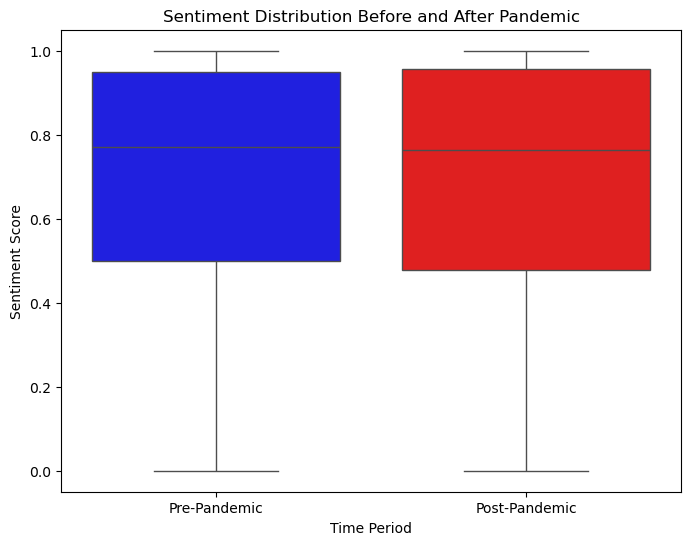

In [1]:
# ========================== Step 1: Import Necessary Libraries ==========================

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt # For data visualization
import seaborn as sns # For enhanced plotting
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation # LDA for topic modeling
import jieba # Chinese word segmentation
import numpy as np

# ========================== Step 2: Load and Prepare Data ==========================

# Define file path for the dataset containing sentiment analysis results
file_path = "C:\\Users\\wusiq\\Desktop\\2\\bilibili_data_combined_sentiment.csv"
# Load dataset containing text and sentiment scores
df = pd.read_csv(file_path)

# Convert 'time' column to datetime format for time-based filtering
df["time"] = pd.to_datetime(df["time"], errors="coerce")

# Define the pandemic boundary date for pre/post comparison
pandemic_date = datetime(2019, 12, 30)

# Separate the dataset into pre-pandemic and post-pandemic subsets
df_pre = df[df["time"] < pandemic_date] # Data before December 30, 2019
df_post = df[df["time"] >= pandemic_date] # Data after December 30, 2019

# ========================== Step 3: Preprocess Text for NLP Analysis ==========================
def preprocess_text(texts):
    """
    Preprocess text by tokenizing using Jieba and removing stopwords.

    Parameters:
    - texts (list of str): A list of Chinese text entries.

    Returns:
    - list of str: A list of preprocessed and cleaned text.
    """
    # Define common stopwords to remove unimportant words
    stopwords = set([
        "的", "是", "了", "我", "也", "和", "在", "有", "就", "不", "人", "都", "吗", "还", "你", "啊", "呢",
        "这个", "那个", "没有", "就是", "因为", "所以", "可以", "还是", "知道", "觉得", "自己", "时候",
        "如果", "可能", "已经", "应该", "这样", "这样子", "不会", "怎么", "什么", "真的", "比较", "感觉",
        "还是", "其实", "东西", "一下", "一点", "吧", "嘛", "呗", "呀", "噢", "啊啊", "哎", "噗", "诶", "嘿",
        "啦", "呢", "咯", "啦啦", "好像", "非常", "非常好", "这样子", "没啥", "像是", "这种", "那些",
        "所有", "有没有", "之前", "之后", "前面", "后面", "克劳德", "里面", "外面", "视频", "一个", "不是", "一切", "我们", "你们"
    ])
    return [" ".join([word for word in jieba.lcut(text) if word not in stopwords]) for text in texts]

# Preprocess text for both pre-pandemic and post-pandemic datasets
df_pre["cleaned_text"] = preprocess_text(df_pre["text"].dropna().astype(str))
df_post["cleaned_text"] = preprocess_text(df_post["text"].dropna().astype(str))
# ========================== Step 4: Perform LDA Topic Modeling ==========================

def perform_lda(texts, num_topics=5):
    """
    Perform Latent Dirichlet Allocation (LDA) topic modeling.

    Parameters:
    - texts (list of str): A list of preprocessed text.
    - num_topics (int): The number of topics to extract.

    Returns:
    - dict: A dictionary containing topics and their top 10 words.
    """
    vectorizer = CountVectorizer()
    text_matrix = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(text_matrix)
    
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    # Extract top words for each topic
    for topic_idx, topic in enumerate(lda.components_):
        topics[f"Topic {topic_idx+1}"] = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    
    return topics
# Perform LDA for both pre-pandemic and post-pandemic texts
topics_pre = perform_lda(df_pre["cleaned_text"])
topics_post = perform_lda(df_post["cleaned_text"])

# Display the extracted LDA topics before and after the pandemic
print("LDA Topics Before Pandemic:")
for topic, words in topics_pre.items():
    print(f"{topic}: {', '.join(words)}")

print("\nLDA Topics After Pandemic:")
for topic, words in topics_post.items():
    print(f"{topic}: {', '.join(words)}")

# ========================== Step 5: Perform TF-IDF Analysis ==========================
def perform_tfidf(texts):
    """
    Perform TF-IDF vectorization to extract the most important keywords.

    Parameters:
    - texts (list of str): A list of preprocessed text.

    Returns:
    - list of tuples: A sorted list of (word, TF-IDF score) pairs.
    """
    vectorizer = TfidfVectorizer(max_features=20) # Limit to 20 most important words
    text_matrix = vectorizer.fit_transform(texts) # Convert text to TF-IDF matrix
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = np.asarray(text_matrix.mean(axis=0)).flatten()
    return sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)

# Compute TF-IDF for both pre-pandemic and post-pandemic texts
tfidf_pre = perform_tfidf(df_pre["cleaned_text"])
tfidf_post = perform_tfidf(df_post["cleaned_text"])

# Display the top 20 most important words before and after the pandemic
print("\nTop 20 TF-IDF Words Before Pandemic:")
for word, score in tfidf_pre:
    print(f"{word}: {score:.4f}")

print("\nTop 20 TF-IDF Words After Pandemic:")
for word, score in tfidf_post:
    print(f"{word}: {score:.4f}")

# ========================== Step 6: Visualize Sentiment Distribution ==========================

# Generate sentiment boxplot to compare emotional changes before and after the pandemic
plt.figure(figsize=(8, 6))
sns.boxplot(x=["Pre-Pandemic"]*len(df_pre) + ["Post-Pandemic"]*len(df_post), 
            y=list(df_pre["sentiment"]) + list(df_post["sentiment"]),
            palette=["blue", "red"])

plt.title("Sentiment Distribution Before and After Pandemic")
plt.ylabel("Sentiment Score")
plt.xlabel("Time Period")
plt.show()


In [8]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/13.3 MB 9.1 MB/s eta 0:00:02
   ----------- ---------------------------- 3.9/13.3 MB 9.4 MB/s eta 0:00:01
   ------------------- -------------------- 6.6/13.3 MB 10.3 MB/s eta 0:00:01
   --------------------------- ------------ 9.2/13.3 MB 11.0 MB/s eta 0:00:01
   ----------------------------------- ---- 11.8/13.3 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 11.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/820.7 kB ? eta -:--:--
   ---------------------------------------- 820.7/820.7 kB 8.9 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


08:35:03 - cmdstanpy - INFO - Chain [1] start processing
08:35:05 - cmdstanpy - INFO - Chain [1] done processing


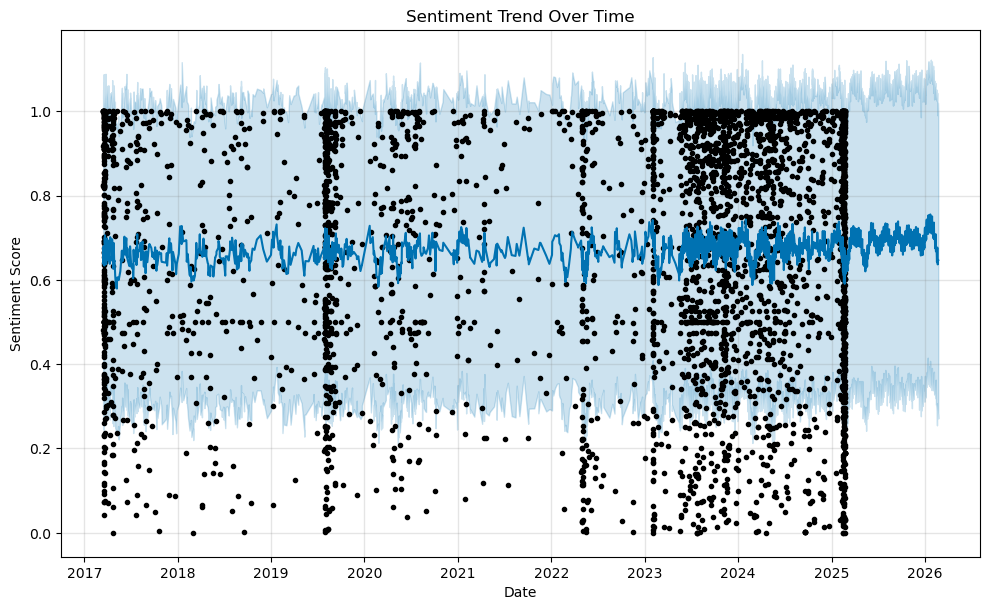

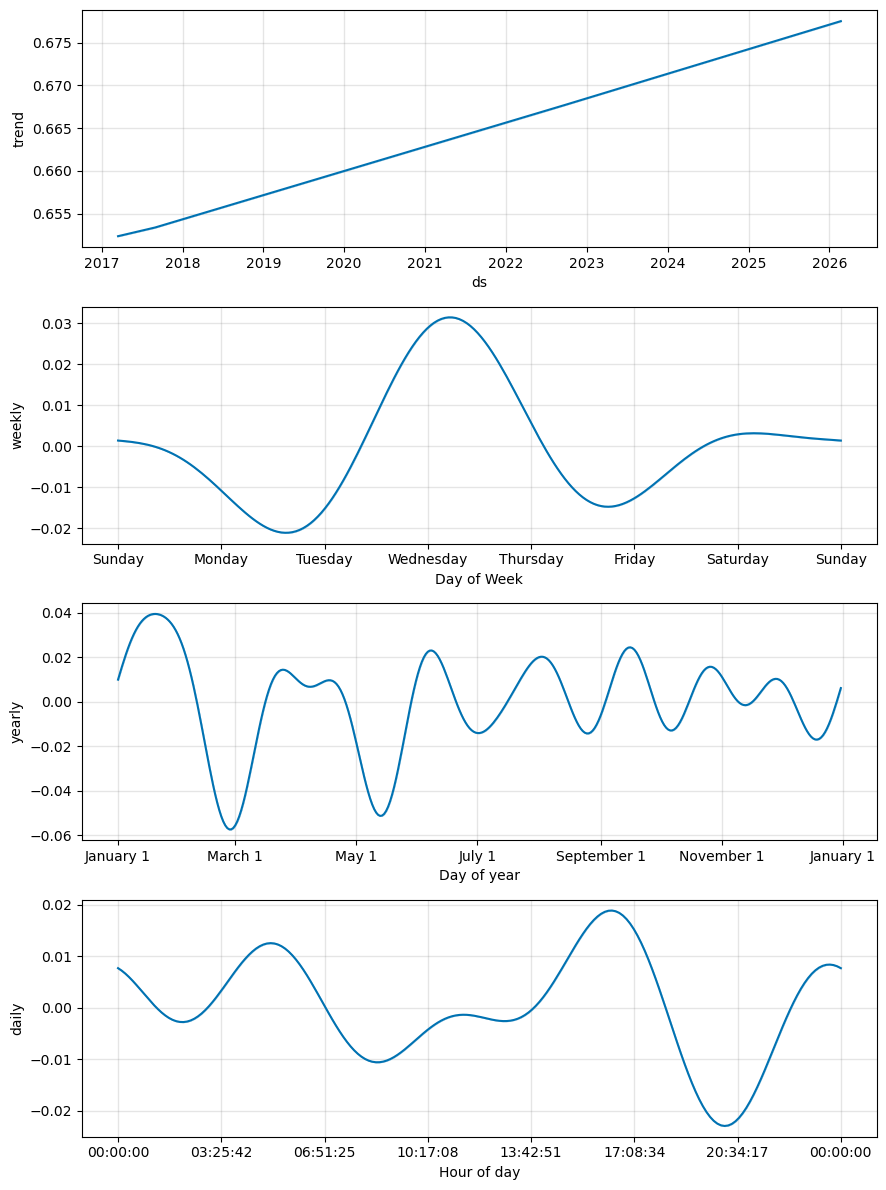

In [9]:
# ========================== Step 1: Import Necessary Libraries ==========================

# Import necessary libraries
import pandas as pd # For data manipulation
from prophet import Prophet # Facebook Prophet for time series forecasting
import matplotlib.pyplot as plt # For data visualization


# ========================== Step 2: Load and Prepare Data ==========================

# Define the file path for the dataset
file_path = r"C:\Users\wusiq\Desktop\2\bilibili_data_augmented.csv"

# Load the dataset containing sentiment scores
df = pd.read_csv(file_path)

# Convert the "time" column to datetime format for time series analysis
df["time"] = pd.to_datetime(df["time"])

# Remove rows where "sentiment" values are missing
df = df.dropna(subset=["sentiment"])

# ========================== Step 3: Format Data for Prophet Model ==========================

# Rename columns to fit Prophet's expected input format:
# "ds" -> Datetime column (time series index)
# "y"  -> Target variable (sentiment score to forecast)
df_prophet = df[["time", "sentiment"]].rename(columns={"time": "ds", "sentiment": "y"})

# Aggregate sentiment scores by date to calculate daily averages
df_prophet = df_prophet.groupby("ds").mean().reset_index()

# ========================== Step 4: Train Prophet Model ==========================

# Initialize the Prophet model with default settings
model = Prophet()

# Train (fit) the model using the sentiment time series data
model.fit(df_prophet)

# ========================== Step 5: Generate Future Predictions ==========================

# Create a dataframe for future predictions extending 365 days into the future
future = model.make_future_dataframe(periods=365)

# Use the trained model to predict sentiment trends for future dates
forecast = model.predict(future)

# ========================== Step 6: Visualizing Sentiment Trends ==========================

# Plot the sentiment forecast over time
fig = model.plot(forecast)
plt.title("Sentiment Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.show()

# Plot trend components (overall trend, weekly patterns, and yearly seasonality)
fig2 = model.plot_components(forecast)
plt.show()
